In [1]:
import requests
import pandas as pd 
import numpy as np

In [55]:
df_vc = pd.read_excel('data\投资机构数据位置-20240408.xlsx',index_col=0)#投资机构数据-20240408.xls
df_gaoxin = pd.read_excel('data\高新技术企业.xlsx')
df_gaoxin['高科技企业'] = 1
df_gaoxin = df_gaoxin[['企业名称','高科技企业']]
df_1=pd.read_excel('data\公司融资数据整理修正-20240301.xlsx',index_col=0)
df_1 = pd.merge(df_gaoxin,df_1,left_on=['企业名称'],right_on=['工商全称'],how='right')
df_1['高科技企业'] = df_1['高科技企业'].fillna(0)

In [42]:
df_vc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4519 entries, 0 to 4518
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4519 non-null   int64  
 1   机构ID        4519 non-null   int64  
 2   机构名称        4519 non-null   object 
 3   机构简介        4519 non-null   object 
 4   机构类型        4519 non-null   object 
 5   管理资本规模      4519 non-null   object 
 6   总投资数量       4519 non-null   int64  
 7   机构官网        2902 non-null   object 
 8   退出数量        4519 non-null   int64  
 9   成立时间        4519 non-null   object 
 10  关注领域        4511 non-null   object 
 11  投资阶段        4519 non-null   object 
 12  机构地址        4054 non-null   object 
 13  邮箱          3182 non-null   object 
 14  电话          3170 non-null   object 
 15  省           2289 non-null   object 
 16  市           2289 non-null   object 
 17  经度          4049 non-null   float64
 18  纬度          4049 non-null   float64
 19  地址提取        1765 non-null  

In [4]:
df_1.columns

Index(['企业名称', '高科技企业', '公司简称', '工商全称', '成立时间', '公司简介', '省', '市', '行业', '子行业',
       '融资时间', '轮次', '金额', '币种', '等值人民币（万）', '投资机构', '估算估值', '行业序号', '简称_全称',
       '公司序号', '北上广深', '风投机构数量'],
      dtype='object')

In [9]:
df_1.企业名称.nunique(),df_1.公司序号.nunique()

(12276, 25155)

In [7]:
df_1.count()

企业名称        26151
高科技企业       48082
公司简称        48082
工商全称        47758
成立时间        48082
公司简介        48080
省           48082
市           48076
行业          48082
子行业         48082
融资时间        47881
轮次          47881
金额          47881
币种          47881
等值人民币（万）    47639
投资机构        35597
估算估值        23598
行业序号        48082
简称_全称       25283
公司序号        48082
北上广深        48082
风投机构数量      35597
dtype: int64

In [30]:
def get_amap_location(address):
    try:
        response = requests.get(url="https://restapi.amap.com/v3/geocode/geo?parameters", 
                                params=
                                {   "address":    address,
                                    "output":    "json",
                                    "key":       '',
                                })
        if response:
            js=response.json()
            #print(js,len(js['geocodes']))
            if js['status']=='1':
                s1,s2=js['geocodes'][0]['location'].split(',')
                return float(s1),float(s2)#,js['geocodes'][0]['formatted_address']
    except:
        print(address)
    
    return np.nan,np.nan #,''

def get_bmap_location(address):
    response = requests.get(url="https://api.map.baidu.com/geocoding/v3", 
                            params=
                                {   "address":   address,
                                    "output":   "json",
                                    "ak":       "",
                                })
    if response:
        dic=response.json()['result']['location']
        return round(dic['lng'],6),round(dic['lat'],6)

In [30]:
citys=df_1[['省','市']].drop_duplicates()
#get_bmap_location('北京朝阳区')

In [36]:
citys['经度'],citys['纬度']=zip(*citys['省'].str.cat(citys['市']).apply(get_amap_location))

In [38]:
citys.to_excel('data/中国城市location.xlsx')

In [117]:
citys=pd.read_excel('data/中国城市location.xlsx',index_col=0)

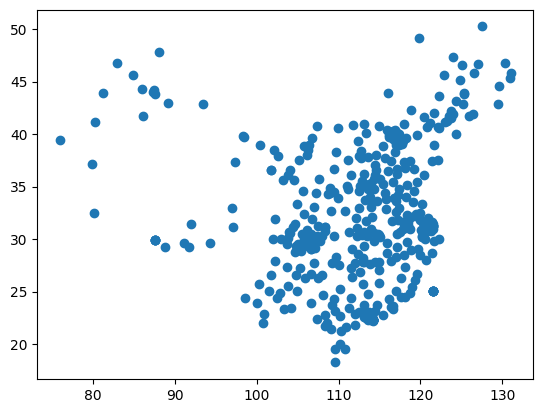

In [67]:
import matplotlib.pylab as plt
plt.scatter(citys['经度'],citys['纬度'])

In [159]:
df_1=pd.merge(df_1,citys,on=['省','市'],how='left')

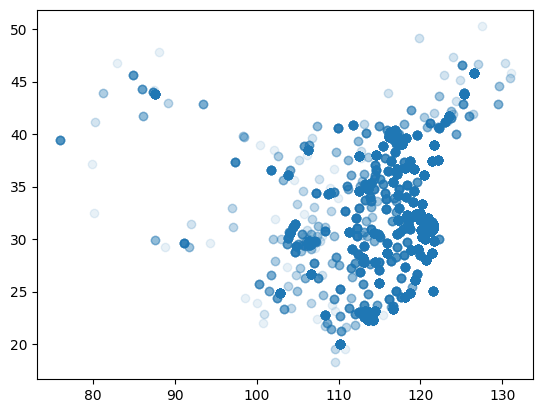

In [73]:
plt.scatter(df_1['经度'],df_1['纬度'],alpha=0.1)

In [15]:
df_vc.机构地址.nunique(),df_vc.机构地址

(3882,
 0                         上海南京西路1366号恒隆广场2号楼3006
 1                     上海市静安区南京西路1539号静安嘉里中心二座41层
 2                       静安区南京西路1717号会德丰国际广场2205室
 3                         北京市朝阳区建外大街1号国贸写字楼1座324
 4                        上海市徐汇区复兴中路1350弄6号200031
                           ...                   
 4514                                         NaN
 4515    中国（河北）自由贸易试验区大兴机场片区廊坊临空经济区航谊道自贸区科创基地2296
 4516                                 国际金融二期3501室
 4517                        上海市松江区泗泾镇方泗公路18号2幢1层
 4518                 上海市崇明区东平镇东风公路399号（东平镇经济开发区）
 Name: 机构地址, Length: 4519, dtype: object)

In [54]:
import re
for idx, address in df_vc.机构地址.dropna().items():
    #print(idx,address)
    for row in citys.itertuples():
        pattern =  fr"{row.省}(?:[\u4e00-\u9fa5\s]*?){row.市}" 
        #print(pattern,address)
        match = re.search(pattern, address)
        if match:
            df_vc.loc[idx, '省'] = row.省
            df_vc.loc[idx, '市'] = row.市
            df_vc.loc[idx, '经度'] = row.经度
            df_vc.loc[idx, '纬度'] = row.纬度
            break  # 匹配成功后跳出本次循环，避免同一地址有多次匹配的情况

df_vc.count()

机构ID      4519
机构名称      4519
机构简介      4519
机构类型      4519
管理资本规模    4519
总投资数量     4519
机构官网      2902
退出数量      4519
成立时间      4519
关注领域      4511
投资阶段      4519
机构地址      4054
邮箱        3182
电话        3170
省         2289
市         2289
经度        2289
纬度        2289
dtype: int64

In [55]:
df_vc.loc[df_vc.市.isna(),'地址提取']=df_vc.loc[df_vc.市.isna(),'机构地址'].str.extract("^(.*?[区|路]|[\u4e00-\u9fa5\s]+)")[0]
df_vc['地址提取'].nunique()

653

In [58]:
city1=df_vc.loc[df_vc.市.isna(),'地址提取'].dropna().drop_duplicates().to_frame()#df_vc.loc[df_vc.市.isna(),'地址提取'].nunique()
len(city1)

653

In [60]:
city1['经度'],city1['纬度']=zip(*city1['地址提取'].apply(get_amap_location))

In [62]:
city1.to_excel('data/城市location_2.xlsx')
city1

,地址提取,经度,纬度
0,上海南京西路,121.456868,31.228371
2,静安区,121.447348,31.227718
5,上海市南京西路,121.450721,31.225146
10,新加坡,107.818802,35.058746
11,徐汇区,121.436307,31.188334
...,...,...,...
4457,成都天府产业孵化园,104.062057,30.547429
4458,苏州市高新区,120.553540,31.300080
4465,太仓港经济技术开发区,121.206601,31.624863
4508,新余市高新开发区,114.967179,27.820715


In [39]:
# merged_df = pd.merge(df2, df1[['ID', 'City']], on='ID', suffixes=('_df2', '_df1'))
# # 然后使用 'City_df1' 中的值填充 'City_df2' 中的空值
# merged_df['City_df2'].fillna(merged_df['City_df1'], inplace=True)
# # 删除多余的 'City_df1' 列
# merged_df.drop(columns=['City_df1'], inplace=True)

In [63]:
df_vc.loc[df_vc.经度.isna()&(~df_vc.地址提取.isna()),'经度']=df_vc.loc[df_vc.经度.isna()&(~df_vc.地址提取.isna()),'地址提取'].map(city1.set_index('地址提取')['经度'].to_dict())
df_vc.loc[df_vc.纬度.isna()&(~df_vc.地址提取.isna()),'纬度']=df_vc.loc[df_vc.纬度.isna()&(~df_vc.地址提取.isna()),'地址提取'].map(city1.set_index('地址提取')['纬度'].to_dict())

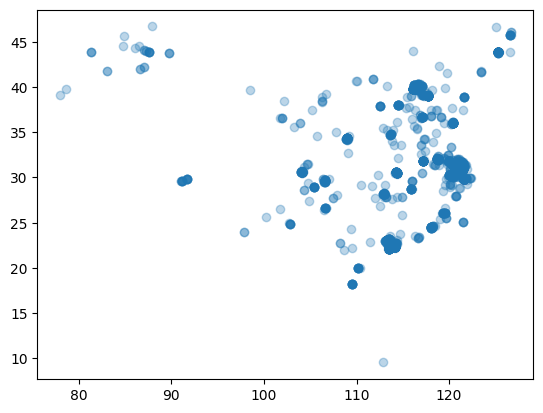

In [74]:
plt.scatter(df_vc['经度'],df_vc['纬度'],alpha=0.3)

In [64]:
df_vc.to_excel('data\投资机构数据位置-20240408.xlsx')

In [57]:
df_vc.columns

Index(['机构ID', '机构名称', '机构简介', '机构类型', '管理资本规模', '总投资数量', '机构官网', '退出数量',
       '成立时间', '关注领域', '投资阶段', '机构地址', '邮箱', '电话', '省', '市', '经度', '纬度',
       '地址提取', 'vc_rep'],
      dtype='object')

In [56]:
df_vc['vc_rep'] =  np.log(1+df_vc['退出数量'])
#df_vc['经纬度'] = df_vc['机构地址'].apply(lambda x: get_bmap_location(x))

In [48]:
vc=df_1['投资机构'].str.split('|',expand=True).stack().replace('',np.nan).dropna().str.strip().reset_index(level=1, drop=True).rename('投资机构')
vc_id=vc.drop_duplicates(keep='first').reset_index()
vc_id=pd.Series(vc_id.index,index=vc_id.values[:,1]).to_dict()

In [49]:
col=df_1.columns[10:15].to_list()+['公司简称','公司序号','子行业']
col

['融资时间', '轮次', '金额', '币种', '等值人民币（万）', '公司简称', '公司序号', '子行业']

In [50]:
df_vc_1=pd.merge(pd.concat([vc,vc.map(vc_id).rename('VC序号')],axis=1),df_1[col],
               left_index=True,right_index=True).sort_values(['VC序号','融资时间','公司序号']).reset_index()

这里投资机构的领投机构的判断标准：  
1）首先看截止到该轮投资之前投资机构参与次数最多的   
2）如果投资机构参与次数一样的话，看最先投资的   
3）如果都满足的，就保留这几家vc，求一下前面两个变量的平均值  

In [51]:
df_vc_1.columns

Index(['index', '投资机构', 'VC序号', '融资时间', '轮次', '金额', '币种', '等值人民币（万）', '公司简称',
       '公司序号', '子行业'],
      dtype='object')

In [26]:
df_1.columns

Index(['企业名称', '高科技企业', '公司简称', '工商全称', '成立时间', '公司简介', '省', '市', '行业', '子行业',
       '融资时间', '轮次', '金额', '币种', '等值人民币（万）', '投资机构', '估算估值', '行业序号', '简称_全称',
       '公司序号', '北上广深', '风投机构数量'],
      dtype='object')

In [54]:
#df_1['机构名称']=df_1['投资机构'].dropna().apply(lambda x:[y.strip() for y in x.split('|') if y])

In [153]:
df_1['Cum_invset']=df_1.groupby('公司序号')['融资时间'].transform(lambda x: x.rank(method='first'))

In [73]:
def get_vc_first(row):
    if pd.isna(row['投资机构']):
        return

    vc_name=[y.strip() for y in row['投资机构'].split('|') if y]

    if len(vc_name)==1:
        return [vc_name[0]]

    if row['Cum_invset']==1:
        return vc_name

    filter_value=df_vc_1[(df_vc_1['公司序号']==row['公司序号'])&
                        df_vc_1['投资机构'].isin(vc_name)&
                        (df_vc_1['融资时间']<row['融资时间'])]
                        
    if not filter_value.empty:
        s1=filter_value['投资机构'].value_counts()
        max_values=s1[0]
        max_values_index = s1.index[s1.values == max_values]
        if len(max_values_index)==1:
            return [s1.index[0]]
            
        filter_value2=filter_value[filter_value['投资机构'].isin(max_values_index)].sort_values('融资时间')
        first_row=filter_value2.iloc[0]
        if (filter_value2['融资时间']==first_row['融资时间']).sum()==1:
            return [first_row['投资机构']]

        return vc_name


In [74]:
df_1['vc_first']=df_1.apply(get_vc_first,axis=1)

In [189]:
df_1['vc_first'].explode().value_counts()

vc_first
深创投         498
红杉中国        365
同创伟业        266
IDG资本       261
毅达资本        254
           ... 
维科控股          1
国盛华兴          1
嘉麟杰-CVC       1
苏州龙驹东方投资      1
朗姿股份-CVC      1
Name: count, Length: 13801, dtype: int64

In [105]:
df_1.count()

企业名称          26151
高科技企业         48082
公司简称          48082
工商全称          47758
成立时间          48082
公司简介          48080
省             48082
市             48076
行业            48082
子行业           48082
融资时间          47881
轮次            47881
金额            47881
币种            47881
等值人民币（万）      47639
投资机构          35597
估算估值          23598
行业序号          48082
简称_全称         25283
公司序号          48082
北上广深          48082
风投机构数量        35597
机构名称          35597
Cum_invset    47881
vc_first      29271
dtype: int64

In [44]:
df_1=pd.read_excel('data/公司融资数据位置&投资机构-20240301.xlsx',index_col=0)

In [114]:
def get_vc_first_hy(row):
    if not row['vc_first']:
        return np.nan
        
    last_date = row.融资时间
    filter_value=df_vc_1[df_vc_1['投资机构'].isin(row['vc_first'])&
                        (df_vc_1['子行业']==row['子行业'])&
                        (last_date > df_vc_1['融资时间'])&(df_vc_1['融资时间'] > last_date-pd.Timedelta(days=5*365))]
    if filter_value.empty:#行业首投,>=历史
        return 0
    return np.log10(filter_value.shape[0]/filter_value['投资机构'].nunique(dropna=True)+1)

In [59]:
df_1['融资时间']=pd.to_datetime(df_1['融资时间'])
df_vc_1['融资时间']=pd.to_datetime(df_vc_1['融资时间'])

In [63]:
import ast
df_1['vc_first']=df_1['vc_first'].dropna().apply(lambda x: ast.literal_eval(x))

In [115]:
%%time
df_1['VC行业经验']=df_1.apply(get_vc_first_hy,axis=1)
df_1['VC行业经验'].describe()

CPU times: total: 9min 25s
Wall time: 9min 25s


count    29271.000000
mean         0.319776
std          0.419810
min          0.000000
25%          0.000000
50%          0.000000
75%          0.477121
max          2.079181
Name: VC行业经验, dtype: float64

In [124]:
df_vc.成立时间=pd.read_excel('data\投资机构数据位置-20240408.xlsx',index_col=0)['成立时间']

In [145]:
df_vc['成立时间'].value_counts()

成立时间
2015-1     110
2014-1      98
-           88
2016-1      85
2015-7      71
          ... 
1995-2       1
1991-6       1
1996-11      1
1917-7       1
2024-3       1
Name: count, Length: 420, dtype: int64

In [148]:
df_vc['成立时间_fmt']=pd.to_datetime(df_vc['成立时间'].replace('-',np.nan),format='%Y-%m')

In [126]:
from datetime import datetime
datetime.strptime('2005-9', '%Y-%m')

datetime.datetime(2005, 9, 1, 0, 0)

In [130]:
(df_1.iloc[0]['融资时间']-datetime.strptime('2005-9', '%Y-%m')).days

3529

In [168]:
def get_vc_first_mkt(row):
    if not row['vc_first']:
        return np.nan
        
    if not row['融资时间']:
      return np.nan
    
    filter_value=df_vc[df_vc['机构名称'].isin(row['vc_first'])].dropna(subset=['成立时间_fmt'])

    if filter_value.empty:
      return np.nan
    #(row['融资时间']-filter_value['成立时间'].map(lambda x:datetime.strptime(x, '%Y-%m'))).dt.days
    difference_days =(row['融资时间']-filter_value['成立时间_fmt']).dt.days
    mask=(difference_days <= 0)
    if mask.sum()>0:
      print(row['融资时间'],'....',filter_value['成立时间_fmt'].to_list())
      print(difference_days,'difference_days:',difference_days.mean())
    
    
    return np.log10(difference_days[~mask].mean() // 365 + 1)

In [170]:
# df_vc['VC存续时间']=df_vc.groupby('投资机构')['融资时间'].transform(lambda x:(x-x.min()).dt.days)
# df_vc['VC_mktexp']=np.log10(df_vc['存续时间']//365+1)

df_1['vc_mktexp']=df_1.apply(get_vc_first_mkt,axis=1)

2014-03-01 00:00:00 .... [Timestamp('2014-05-01 00:00:00'), Timestamp('2010-08-01 00:00:00')]
103     -61
128    1308
Name: 成立时间_fmt, dtype: int64 difference_days: 623.5
2001-08-01 00:00:00 .... [Timestamp('2002-10-01 00:00:00')]
24   -426
Name: 成立时间_fmt, dtype: int64 difference_days: -426.0
2014-04-01 00:00:00 .... [Timestamp('2015-05-01 00:00:00')]
510   -395
Name: 成立时间_fmt, dtype: int64 difference_days: -395.0
2011-05-21 00:00:00 .... [Timestamp('2014-12-01 00:00:00')]
749   -1290
Name: 成立时间_fmt, dtype: int64 difference_days: -1290.0
2012-05-03 00:00:00 .... [Timestamp('2001-01-01 00:00:00'), Timestamp('2012-12-01 00:00:00')]
411     4140
2906    -212
Name: 成立时间_fmt, dtype: int64 difference_days: 1964.0
2009-08-01 00:00:00 .... [Timestamp('2006-03-01 00:00:00'), Timestamp('1992-01-01 00:00:00'), Timestamp('2014-02-01 00:00:00'), Timestamp('2005-01-01 00:00:00'), Timestamp('2009-01-01 00:00:00')]
88      1249
292     6422
343    -1645
1198    1673
1288     212
Name: 成立时间_fmt, dtype: 

In [171]:
df_1['vc_mktexp'].describe()

count    20151.000000
mean         0.881419
std          0.331778
min          0.000000
25%          0.698970
50%          0.903090
75%          1.113943
max          2.184691
Name: vc_mktexp, dtype: float64

In [173]:
def get_vc_first_rep(row):
    if not row['vc_first']:
        return np.nan
        
    filter_value=df_vc[df_vc['机构名称'].isin(row['vc_first'])].dropna(subset=['退出数量'])

    if filter_value.empty:
      return np.nan
    
    return np.log10(filter_value['退出数量'].mean() + 1)#一个机构一条

In [174]:
#df_vc['vc_rep'] =  np.log(1+df_vc['退出数量'])

df_1['vc_rep']=df_1.apply(get_vc_first_rep,axis=1)

In [175]:
df_1.columns

Index(['企业名称', '高科技企业', '公司简称', '工商全称', '成立时间', '公司简介', '省', '市', '行业', '子行业',
       '融资时间', '轮次', '金额', '币种', '等值人民币（万）', '投资机构', '估算估值', '行业序号', '简称_全称',
       '公司序号', '北上广深', '风投机构数量', 'Cum_invset', 'vc_first', 'VC行业经验', '经度',
       '纬度', 'vc_distance', 'vc_mktexp', 'vc_rep'],
      dtype='object')

In [176]:
df_1.to_excel('data/公司融资数据位置&投资机构-20240301.xlsx')

In [5]:
import math

def latlong_distance(lat1, lon1, lat2, lon2):
    # 将角度转为弧度
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    R = 6371.0 # 地球平均半径，公里

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
   

    # 计算直角坐标系中的两点之间的距离
    # x = dlon * math.cos(0.5 * (lat2 + lat1))
    # distance = R * math.sqrt(x**2 + dlat**2)

    # # 应用球面三角形余弦定理
    # central_angle = math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(dlon))
    # # 使用中心角和地球的半径计算距离
    # distance = R * central_angle

    # 计算两个法向量之间的夹角
    # dot_product = math.cos(lat1) * math.cos(lon1) * math.cos(lat2) * math.cos(lon2) +
    #              math.cos(lat1) * math.sin(lon1) * math.cos(lat2) * math.sin(lon2) +
    #              math.sin(lat1) * math.sin(lat2)
    # distance = R * math.acos(dot_product)

    return R * c 

In [161]:
df_1.iloc[0].市,df_1.iloc[10000].市

('朝阳区', '浦东新区')

In [162]:
latlong_distance(df_1.iloc[0].纬度, df_1.iloc[0].经度, df_1.iloc[10000].纬度, df_1.iloc[10000].经度)

1071.277558387631

In [164]:
df_vc.columns

Index(['机构ID', '机构名称', '机构简介', '机构类型', '管理资本规模', '总投资数量', '机构官网', '退出数量',
       '成立时间', '关注领域', '投资阶段', '机构地址', '邮箱', '电话', '省', '市', '经度', '纬度',
       '地址提取', 'vc_rep'],
      dtype='object')

In [167]:
def vc_distance(row):
    if not row['vc_first']:
      return np.nan
    if not row.纬度:
      return np.nan
    filter_value=df_vc[df_vc['机构名称'].isin(row['vc_first'])].dropna(subset=['纬度'])
    if filter_value.empty:
      return np.nan
    filter_value['distance']=filter_value.apply(lambda x:latlong_distance(row.纬度, row.经度, x.纬度, x.经度),axis=1)
    return filter_value['distance'].mean()


In [169]:
df_1['vc_distance']=df_1.apply(vc_distance,axis=1)

In [195]:
df_1.shape,df_1.count()

((48082, 30),
 企业名称           26151
 高科技企业          48082
 公司简称           48082
 工商全称           47758
 成立时间           48082
 公司简介           48080
 省              48082
 市              48076
 行业             48082
 子行业            48082
 融资时间           47881
 轮次             47881
 金额             47881
 币种             47881
 等值人民币（万）       47639
 投资机构           35597
 估算估值           23598
 行业序号           48082
 简称_全称          25283
 公司序号           48082
 北上广深           48082
 风投机构数量         35597
 Cum_invset     47881
 vc_first       29271
 VC行业经验         29271
 经度             48082
 纬度             48082
 vc_distance    19556
 vc_mktexp      20151
 vc_rep         20515
 dtype: int64)

In [178]:
df_patent_invest=pd.read_excel('data//patent_invest_2024_先进制造_医疗健康_2.xlsx',index_col=0)

In [ ]:
df_patent_invest.shape

In [181]:
del df_patent_invest['vc_first']
del df_patent_invest['vc_distance']
del df_patent_invest['VC行业经验']

In [182]:
set(df_1.columns)-set(df_patent_invest.columns)

{'VC行业经验',
 'vc_distance',
 'vc_first',
 'vc_mktexp',
 'vc_rep',
 '企业名称',
 '简称_全称',
 '行业序号',
 '风投机构数量'}

In [185]:
df_patent_invest.columns

Index(['公司序号', '公司简称', '工商全称', '成立时间', '公司简介', '省', '市', '行业', '子行业', '经度',
       '纬度', '估算估值', '首次上市日期', '目前已上市', '高科技企业', '北上广深', '成立年份', '融资年份',
       '融资时间', '轮次', '金额', '币种', '等值人民币（万）', '投资机构', 'VC_Amount', 'Cum_invset',
       'Age', 'VC-num', '有披露', '上市Days', '观察年', '是否融资', '投资时间_Shift',
       'Application_num', 'IPC主分类_去重', 'IPC主分类_平均', 'IPC_个数_去重', 'IPC_个数_平均',
       '知识宽度', '被引证次数', '引证数量', '引证数量_去重', '引证数量_平均', '简单同族个数', '简单同族_去重',
       '简单同族美日欧_比例', '发明人数量', '发明人数量_去重', '发明人数量_平均', '权利要求数量', '引证科技文献数量',
       '有效数量', '有效_比例', '发明授权', '发明申请', '实用新型', '外观设计'],
      dtype='object')

In [186]:
df_patent_invest['融资时间']=pd.to_datetime(df_patent_invest['融资时间'])

In [187]:
df_patent_invest_1=pd.merge(df_patent_invest,df_1[['公司序号','融资时间','vc_first','vc_distance','VC行业经验','vc_mktexp','vc_rep']],on=['公司序号','融资时间'],how='left')#'高科技企业','经度','纬度'
df_patent_invest_1.shape

(172418, 62)

In [188]:
df_patent_invest_1['vc_first'].explode().value_counts()

vc_first
深创投         377
红杉中国        286
同创伟业        231
启明创投        223
中科创星        204
           ... 
国融工发          1
湖州中小创投        1
合肥芯屏投资        1
合肥市建投集团       1
朗姿股份-CVC      1
Name: count, Length: 10783, dtype: int64

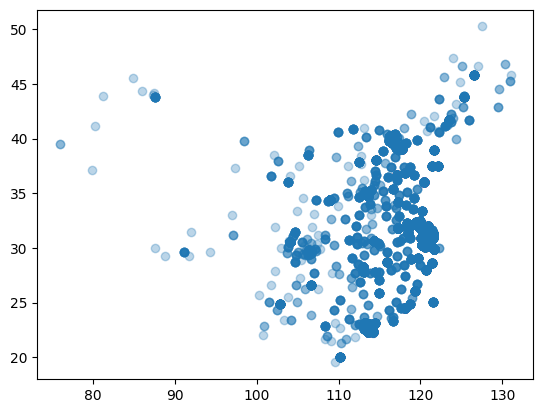

In [192]:
df_co_2=df_patent_invest_1.drop_duplicates('公司序号')
plt.scatter(df_co_2['经度'],df_co_2['纬度'],alpha=0.3)

In [193]:
df_patent_invest_1.to_excel('data//patent_invest_2024_先进制造_医疗健康_3.xlsx')

In [ ]:
group_vc=df_1.groupby('vc_first')#'投资机构'分组分批计算
for vc in group_vc.groups.keys():
    vc_value = group_vc.get_group(vc).sort_values('融资时间',ascending=True) #得到分组
    for index, row in vc_value.iterrows(): #按分出的组再分行
        mask = (df_vc.index == index)      #使用index 标记原始位置
        last_date = row.融资时间
        df_vc.loc[mask,'企业数量']=vc_value[index >= vc_value.index]['公司序号'].dropna().nunique()#去重累加,按标记位置赋值

        filter_value = vc_value[(vc_value['子行业'] == row.子行业)&
                                (last_date >= vc_value['融资时间'])&
                                (vc_value['融资时间'] > last_date-pd.Timedelta(days=5*365))]

        df_vc.loc[mask,'VC行业经验']=np.log10(filter_value.shape[0])#同一子行业投资项目数量+本身